In [1]:
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt

#### Functions

1. User-preferences Weights Calculations - Fuzzy Logic
2. Service QoS Weights Calculations - AHP
3. Normalisation 
4. Final Weights Calculation RAT layer
5. MEW
6. SAW

#### 1. Fuzzy Membership Funtion

In [2]:
def fuzzy_membership(criteria_value, preference, min_value, max_value):
    """
    Calculate the fuzzy membership value for a given criteria.
    
    :param criteria_value: The value of the criteria to evaluate
    :param preference: 'low', 'medium', or 'high'
    :param min_value: The minimum value for the criteria range
    :param max_value: The maximum value for the criteria range
    :return: Membership value between 0 and 1
    """
    
    def low_mf(x, b, c):
        return np.where(x <= b, 1, max(0, (c - x) / (c - b)))
    
    def medium_mf(x, a, b, c):
        return max(0, min((x - a) / (b - a), (c - x) / (c - b)))
    
    def high_mf(x, a, b):
        return np.where(x >= b, 1, max(0, (x - a) / (b - a)))
    
    # Calculate the range
    value_range = max_value - min_value

    preference = preference.lower()
    # Set ratios for a, b, c based on the range
    if preference == 'low':
        b = min_value + 0.25 * value_range
        c = min_value + 0.5 * value_range
        return low_mf(criteria_value, b, c)
    
    elif preference == 'medium':
        a = min_value + 0.25 * value_range
        b = min_value + 0.5 * value_range
        c = min_value + 0.75 * value_range
        return medium_mf(criteria_value, a, b, c)
    
    elif preference == 'high':
        a = min_value + 0.5 * value_range
        b = min_value + 0.75 * value_range
        return high_mf(criteria_value, a, b)
    
    else:
        raise ValueError("Preference must be 'low', 'medium', or 'high'")

In [3]:
def qos_to_no(preference: str) -> float:
    """
    Convert a QoS preference string to its corresponding numerical value.
    
    Args:
    preference (str): A string representing the QoS preference. 
                      Must be either "Low", "Medium", or "High" (case-insensitive).
    
    Returns:
    float: The numerical value corresponding to the preference.
    
    Raises:
    ValueError: If an invalid preference is provided.
    """
    preference_map = {
        "low": 0.01,
        "medium": 0.50,
        "high": 0.99
    }
    
    normalized_preference = preference.lower()
    
    if normalized_preference not in preference_map:
        raise ValueError("Invalid preference. Must be 'Low', 'Medium', or 'High'.")
    
    return preference_map[normalized_preference]

#### 2. AHP Function

In [4]:
def ahp_weights(matrix):
    """
    Calculate weights and Consistency Index for AHP pairwise comparison matrix.
    
    Args:
    matrix (np.array): Square pairwise comparison matrix
    
    Returns:
    tuple: (weights, consistency_index)
    """
    # Check if the matrix is square
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("Matrix must be square")
    
    n = matrix.shape[0]
    
    # Calculate the principal eigenvalue and eigenvector
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    max_index = np.argmax(eigenvalues)
    max_eigenvalue = eigenvalues[max_index].real
    eigenvector = eigenvectors[:, max_index].real
    
    # Normalize the eigenvector to get the weights
    weights = eigenvector / np.sum(eigenvector)
    
    # Calculate the Consistency Index
    ci = (max_eigenvalue - n) / (n - 1)
    
    # Calculate the Random Index
    ri_values = {1: 0, 2: 0, 3: 0.58, 4: 0.9, 5: 1.12, 6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49}
    ri = ri_values.get(n, 1.49)  # Use 1.49 for n > 10
    
    # Calculate the Consistency Ratio
    cr = ci / ri if ri != 0 else 0
    if cr >= 0.1:
        raise ValueError("Not Consistent!")
    
    return weights

#### 3. Normalisation

In [5]:
def square_root_normalize(matrix, criteria_types):
    """
    Normalize the matrix using square root normalization,
    accounting for upward and downward criteria.
    
    :param matrix: numpy array of shape (n_rats, n_criteria)
    :param criteria_types: list of strings, either 'up' or 'down' for each criterion
    :return: normalized matrix
    """
    normalized = np.zeros_like(matrix, dtype=float)
    
    for j in range(matrix.shape[1]):
        if criteria_types[j] == 'up':
            normalized[:, j] = matrix[:, j] / np.sqrt(np.sum(matrix[:, j]**2))
        elif criteria_types[j] == 'down':
            normalized[:, j] = 1 - (matrix[:, j] / np.sqrt(np.sum(matrix[:, j]**2)))
        else:
            raise ValueError(f"Invalid criterion type: {criteria_types[j]}. Must be 'up' or 'down'.")
    
    return normalized

def normalize_rat_criteria(matrix, criteria_types):
    """
    Normalize RAT criteria matrix using Max-Min function.
    
    :param matrix: 2D numpy array where each row represents a RAT and each column a criterion
    :param criteria_types: List of strings ('up' or 'down') indicating whether each criterion is upward or downward
    :return: Normalized matrix
    """
    normalized = np.zeros_like(matrix, dtype=float)
    
    for j in range(matrix.shape[1]):
        column = matrix[:, j]
        col_min, col_max = np.min(column), np.max(column)
        
        if criteria_types[j] == 'up':
            normalized[:, j] = 1 - abs(column - col_max) / (col_max - col_min)
        elif criteria_types[j] == 'down':
            normalized[:, j] = 1 - abs(column - col_min) / (col_max - col_min)
        else:
            raise ValueError(f"Invalid criterion type for column {j}. Must be 'up' or 'down'.")
    
    return normalized

#### 4. Final Weights Calculation

#### 5. MEW

In [6]:
def calculate_mew_scores(decision_matrix, weights_matrix):
    """
    Calculate scores using the Multiple Exponential Weighted (MEW) method with individual weights for each alternative.
    
    Parameters:
    decision_matrix (numpy.ndarray): A normalized decision matrix where rows represent alternatives and columns represent criteria.
    weights_matrix (numpy.ndarray): A matrix of weights where each row corresponds to weights for the respective alternative.
    
    Returns:
    numpy.ndarray: An array of MEW scores for each alternative.
    """
    
    # Ensure inputs are numpy arrays
    decision_matrix = np.array(decision_matrix)
    weights_matrix = np.array(weights_matrix)
    
    # Check if the dimensions of the decision matrix and weights matrix match
    if decision_matrix.shape != weights_matrix.shape:
        raise ValueError("The dimensions of the decision matrix and weights matrix must match.")
    
    # Calculate MEW scores
    weighted_matrix = np.power(decision_matrix, weights_matrix)
    mew_scores = np.prod(weighted_matrix, axis=1)
    
    return mew_scores

#### 6. SAW

In [7]:
def calculate_saw_scores(decision_matrix, weights):
    """
    Calculate scores using the Simple Additive Weighting (SAW) method.
    
    Parameters:
    decision_matrix (numpy.ndarray): A normalized decision matrix where rows represent alternatives and columns represent criteria.
    weights (numpy.ndarray): An array of weights for each criterion.
    
    Returns:
    numpy.ndarray: An array of SAW scores for each alternative.
    """
    
    # Ensure inputs are numpy arrays
    decision_matrix = np.array(decision_matrix)
    weights = np.array(weights)
    
    # Check if the number of weights matches the number of criteria
    if decision_matrix.shape[1] != weights.shape[0]:
        raise ValueError("The number of weights must match the number of criteria (columns) in the decision matrix.")
    
    # Calculate SAW scores
    saw_scores = np.sum(decision_matrix * weights, axis=1)
    
    return saw_scores

#### DATA

In [8]:
file_path = "simulation_data"

Decision Matrix

In [9]:
df = pd.read_csv(file_path+"/decision_matrix.csv",header = None)
P_max = np.max(df[1][1:6].values.astype(np.float64))
P_min = np.min(df[1][1:6].values.astype(np.float64))
C_max = np.max(df[2][1:6].values.astype(np.float64))
C_min = np.min(df[2][1:6].values.astype(np.float64))

#print(P_max, P_min, C_max, C_min)

In [10]:
RATs = df[0][1:6].values

criteria_types = df.iloc[6:,1:].values[0]

dm_rat = df.iloc[1:6,1:7].values.astype(np.float64)
dm_ap = df.iloc[1:6,7:11].values.astype(np.float64)


normal_dm_rat = square_root_normalize(dm_rat, criteria_types[:6])

Service QoS Weights

In [11]:
df = pd.read_csv(file_path+"/pairwise_matrices.csv",header = None)
services = df[0].iloc[[0, 7, 14, 21]].values

df.dropna(inplace = True)

services_weights = np.zeros((4,4)) # 4 services, 4 criteria

rows_per_matrix = len(df) // 4

for i in range(services_weights.shape[0]):
    df_service = df.iloc[rows_per_matrix * i : (rows_per_matrix * (i+1))].iloc[1:5,1:5] # if i<3 else 0
    services_weights[i] = ahp_weights(df_service.values.astype(np.float64))



User Preferences Weights

In [12]:
df = pd.read_csv(file_path+"/user_preferences.csv", index_col = 0)
users_prefs = df.values

In [13]:
def pref_weights(criteria, user_prefs):
    userpref_weights = np.zeros(3)
    userpref_weights[0] = qos_to_no(user_prefs[0])
    userpref_weights[1] = fuzzy_membership(criteria[0],user_prefs[1],P_min,P_max)
    userpref_weights[2] = fuzzy_membership(criteria[1],user_prefs[2],C_min,C_max) #price range across alt 0.01 - 10 $/Gb
    return userpref_weights

In [14]:
def userspref_weights(criteria, users_prefs): # returns a matrix of weights user [1...U] x prefs [Q,P,C]
    userspref_weights = np.zeros_like(users_prefs)
    #print(userspref_weights)
    for i in range(users_prefs.shape[0]):
        userspref_weights[i] = pref_weights(criteria[:2],users_prefs[i])
        #print(pref_weights(criteria[:2],users_prefs[i]))
        #print(userpref_weights[i])
    return userspref_weights

In [15]:
def qos_nomarlisation(user_weights, service_weights):
    normal_uw = user_weights[1:] if np.sum(user_weights[1:]) <= 0 else user_weights[1:]/np.sum(user_weights[1:])
    return np.concatenate((normal_uw * (1 - user_weights[0]) , service_weights * user_weights[0]))

In [16]:
def users_service_weights(criteria, users_prefs, services_weights):
    weights = np.zeros((27,4,6))
    p_and_c = criteria[:2]

    usersprefs_w = userspref_weights(p_and_c, users_prefs) # 27x3 matrix of weights
    for i in range(27):
        for j in range(4):
            weights[i][j] = qos_nomarlisation(usersprefs_w[i],services_weights[j])
    return weights

In [1]:
def rat_users_weights(rat_matrix, users_prefs, services_weights, service):

    rat_user_weights =  np.zeros((5,27,6))

    for i in range(5):# for each RAT compute the user weights for each user 5x27    
        rat_user_weights[i] = users_service_weights(rat_matrix[i],users_prefs,services_weights)[:, service, :] # service 1 at index 0
        #print(rat_user_weights[0])
        #print(users_service_weights(dm_rat[i],users_prefs,services_weights)[:, 0, :])
    return rat_user_weights # 5x27x6

In [2]:
scores = np.zeros((27,5))
rank_1_freq = np.zeros(5, dtype=np.int64)
service = 1
rat_user_weights = rat_users_weights(dm_rat, users_prefs, services_weights, service)

for i in range(27):
    scores[i] = calculate_mew_scores(normal_dm_rat, rat_user_weights[:,i,:]) # 27x5 
    rank_1_freq += scores[i]==np.max(scores[i])
    #print((scores[i]==np.max(scores[i])))
    #print(scores[i])


df_user_per_rat = pd.DataFrame(rank_1_freq.reshape(1,-1), columns=RATs, index=["No of users"])
df_user_per_rat
#rank_1_freq
#np.zeros(5, dtype=np.int64)


NameError: name 'np' is not defined

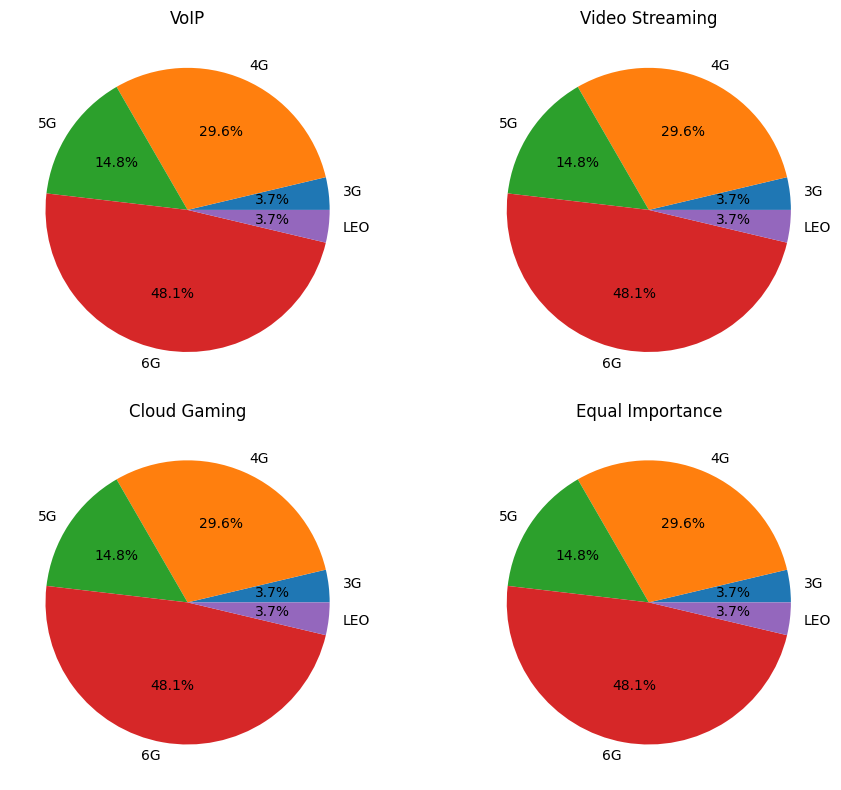

In [19]:
# plt.pie(rank_1_freq, labels=RATs, autopct='%1.1f%%')
# plt.title('Distribution of Users Across Networks')
# plt.show()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for i, service in enumerate(services):
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    # Extract data for the current service
    network_names = RATs
    user_counts = rank_1_freq

    # Create the pie chart
    ax.pie(user_counts, labels=network_names, autopct='%1.1f%%')
    ax.set_title(f'{service}')

plt.tight_layout()
plt.show()